# Chat GPT Reviews Sentiment Analysis

# Imports

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from transformers import AutoTokenizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Functions

In [27]:
def check_for_nulls(df):
  print(f"The Amount of Nulls:{df.isna().sum()}")
  print(f"The Amount of Duplicates:{df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_tokens = re.sub(r"[^a-zA-z\s]", "", word_tokens).split()
  filtered_sentence = [w.lower().strip() for w in filtered_tokens if not w.lower().strip() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

def grouped_insights(df,cols, x, metric_name):
  
  for col in cols:
    grouped_df = df.groupby(x)[col].sum().reset_index() if metric_name == "sum" else df.groupby(x)[col].mean().reset_index() 
    
    plt.figure(figsize=(10, 7))
    sns.barplot(data=grouped_df, x=x, y=col, hue=col)
    plt.title(f"{x} Aggregated by {col} {metric_name}")
    plt.xlabel(x)
    plt.ylabel(f"{col} {metric_name}")
    plt.xticks(rotation=45)
    plt.show()

# EDA Analysis

In [6]:
df = pd.read_csv("/Users/maukanmir/Downloads/chatgpt_reviews.csv", nrows=15000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,26661c9c-2d79-4e19-a7a6-673da6af53f4,Luis Cabrera,magnific!,5,0,1.2024.139,2024-05-29 22:30:43,1.2024.139
1,08d6dd23-e74a-48a5-bab6-7cffa8920a4a,Betty Grayson,it helps me convince my parents to make a mine...,5,0,1.2024.139,2024-05-29 22:29:42,1.2024.139
2,eea7ed5c-b39a-4363-b298-69b6234d0a8a,Abigail Oniyide,"This is the best app I've seen so far, has a l...",5,0,1.2024.131,2024-05-29 22:25:07,1.2024.131
3,b3cf6a61-c88a-4b44-9fec-eb223a1a5109,Sam McGrath,amazing!,5,0,1.2024.131,2024-05-29 22:23:30,1.2024.131
4,15a8fd47-0cf4-447a-a16e-845581e9a448,horii,İnanılmaz.,5,0,1.2024.139,2024-05-29 22:22:29,1.2024.139
...,...,...,...,...,...,...,...,...
14995,fe351276-2e54-4481-b86b-b66e6042ef9f,Thanojreddy Motakatla,very good and fast,5,0,1.2024.115,2024-05-17 03:27:37,1.2024.115
14996,e7c826e7-aade-4902-ae5b-40443286d49a,Prateek Kumar Debta,this app is very good option for children adul...,5,0,1.2024.131,2024-05-17 03:26:50,1.2024.131
14997,4e80301b-e1ea-4a81-9057-30e197895722,Akhasan2002 Love,good,3,0,1.2024.115,2024-05-17 03:26:49,1.2024.115
14998,ebd0836f-d315-40ba-aa07-8bdbb87d64ad,saphaung klein,Great,5,0,1.2024.131,2024-05-17 03:26:13,1.2024.131


# Check For Nulls and Dupes

In [7]:
check_for_nulls(df)

The Amount of Nulls:reviewId                  0
userName                  0
content                   0
score                     0
thumbsUpCount             0
reviewCreatedVersion    787
at                        0
appVersion              787
dtype: int64
The Amount of Duplicates:1201


In [8]:
df.drop_duplicates(inplace=True)

# Check for Class Imbalance

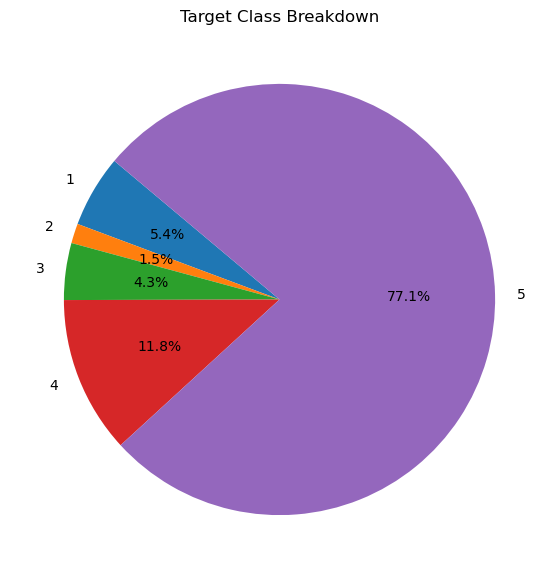

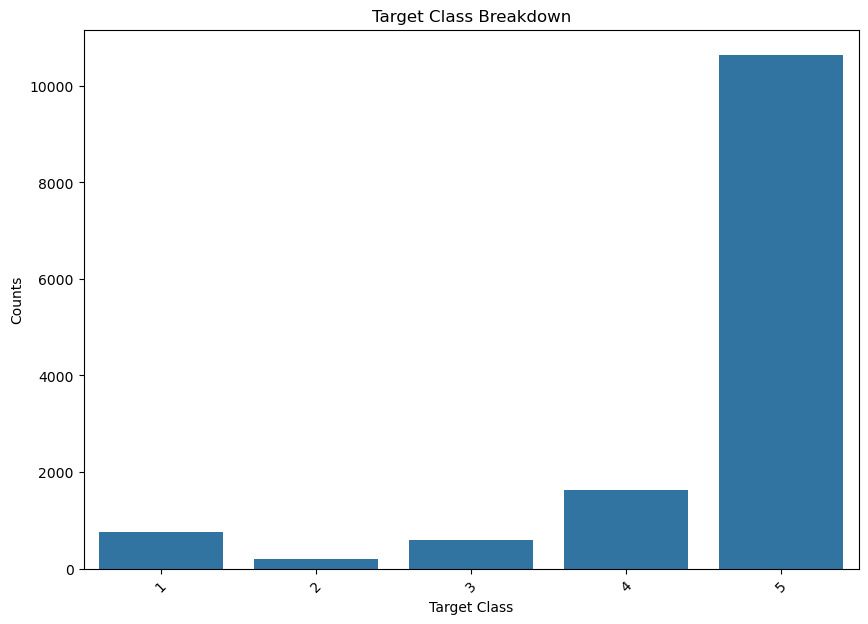

In [9]:
check_class_imbalance(df["score"])

# We have a severe class imbalance in our dataset.

# But people seem to love ChatGPT

# Drop Useless columns

In [10]:
df = df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"], axis=1)

In [11]:
df

,content,score,thumbsUpCount,at
0,magnific!,5,0,2024-05-29 22:30:43
1,it helps me convince my parents to make a mine...,5,0,2024-05-29 22:29:42
2,"This is the best app I've seen so far, has a l...",5,0,2024-05-29 22:25:07
3,amazing!,5,0,2024-05-29 22:23:30
4,İnanılmaz.,5,0,2024-05-29 22:22:29
...,...,...,...,...
13794,good,5,0,2024-05-17 00:19:11
13795,Make Chatgpt free or it's getting useless agai...,3,1,2024-05-17 00:15:17
13796,Omg,5,0,2024-05-17 00:13:42
13797,powerful and fast,5,0,2024-05-17 00:00:35


# Visuals

In [12]:
df["review_length"] = df["content"].apply(lambda review: len(review))
df["word_count"] = df["content"].apply(lambda review: len(review.split()))

In [13]:
df.describe()

,score,thumbsUpCount,review_length,word_count
count,13799.000000,13799.000000,13799.000000,13799.000000
mean,4.536198,0.074281,40.327850,7.610624
std,1.035522,3.082629,67.182511,12.317774
min,1.000000,0.000000,1.000000,1.000000
25%,5.000000,0.000000,8.000000,2.000000
50%,5.000000,0.000000,16.000000,3.000000
75%,5.000000,0.000000,42.000000,8.000000
max,5.000000,186.000000,500.000000,123.000000


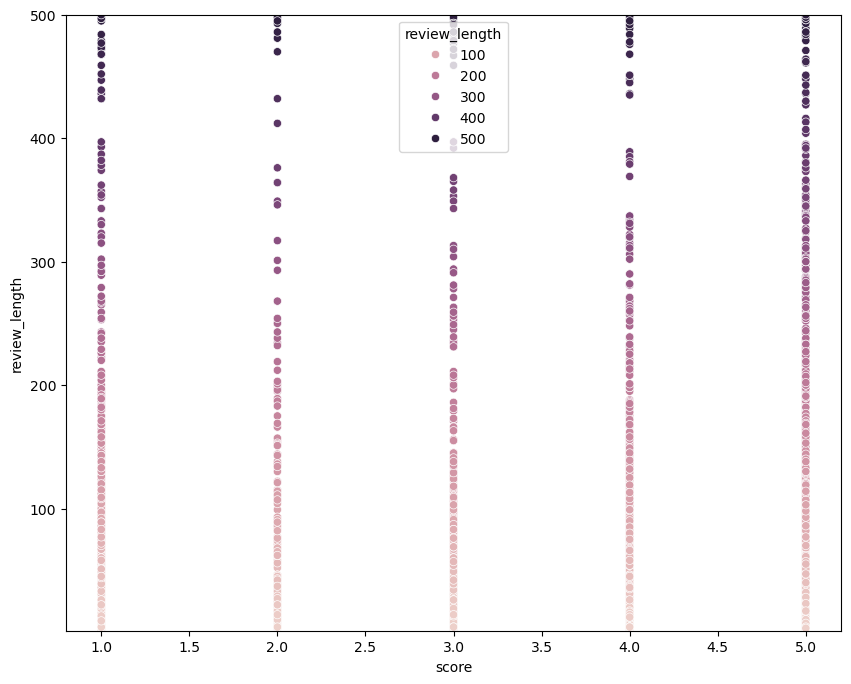

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="score", y="review_length", hue="review_length")
plt.ylim(df["review_length"].min(), df["review_length"].max())
plt.yscale('linear')
plt.show()

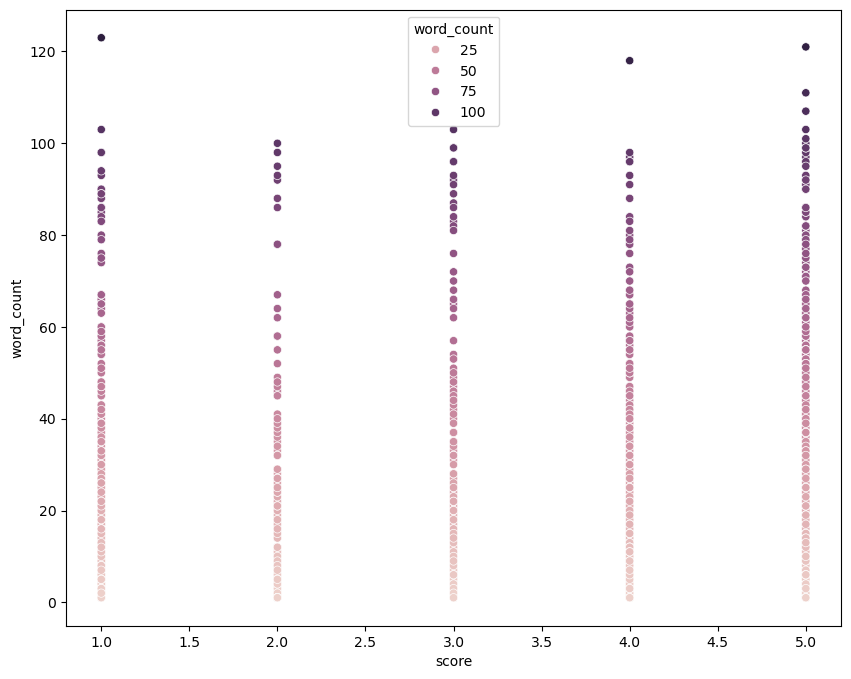

In [15]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="score", y="word_count", hue="word_count")
plt.show()

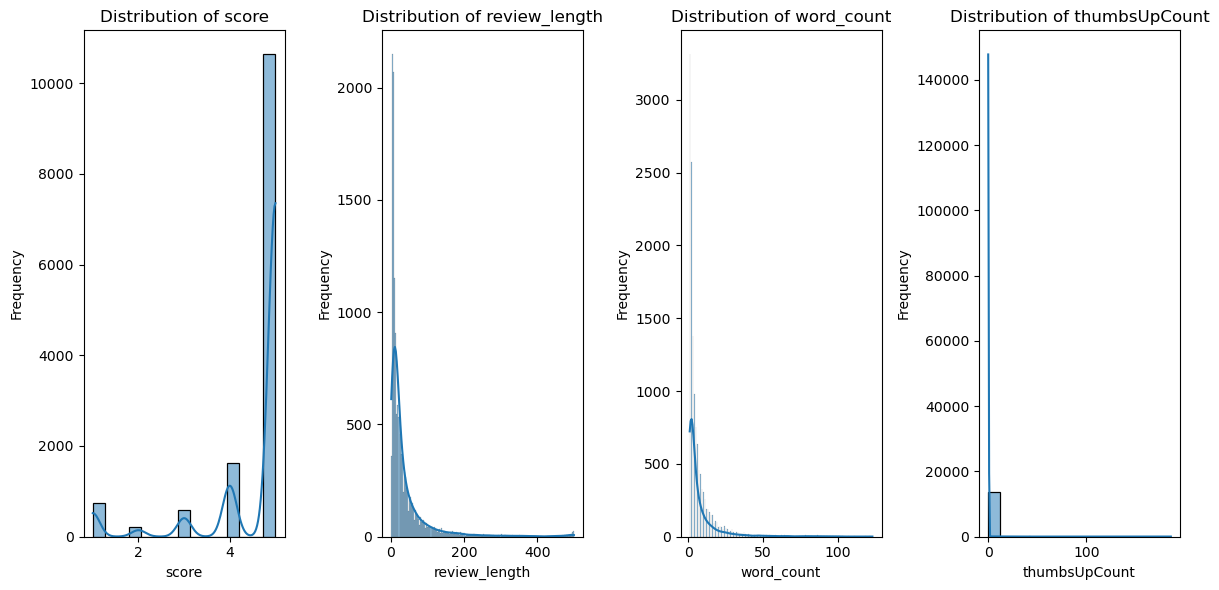

In [24]:
columns = ["score", "review_length", "word_count", "thumbsUpCount"]
plt.figure(figsize=(12,6))
rows = len(columns)
dims = (rows+3)//4

for idx, col in enumerate(columns):
  plt.subplot(dims,4,idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.xlabel(col)
  plt.ylabel("Frequency")
  
plt.tight_layout()
plt.show()

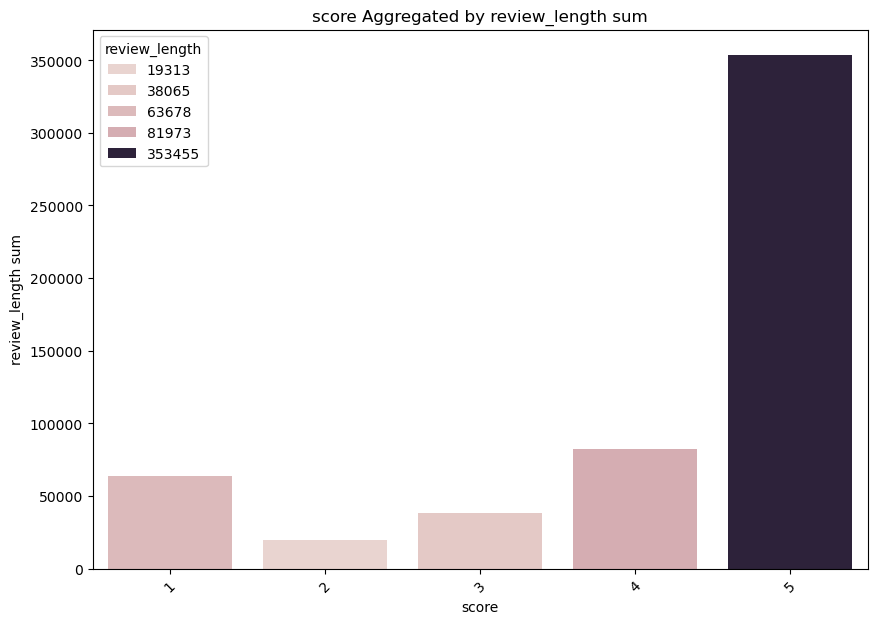

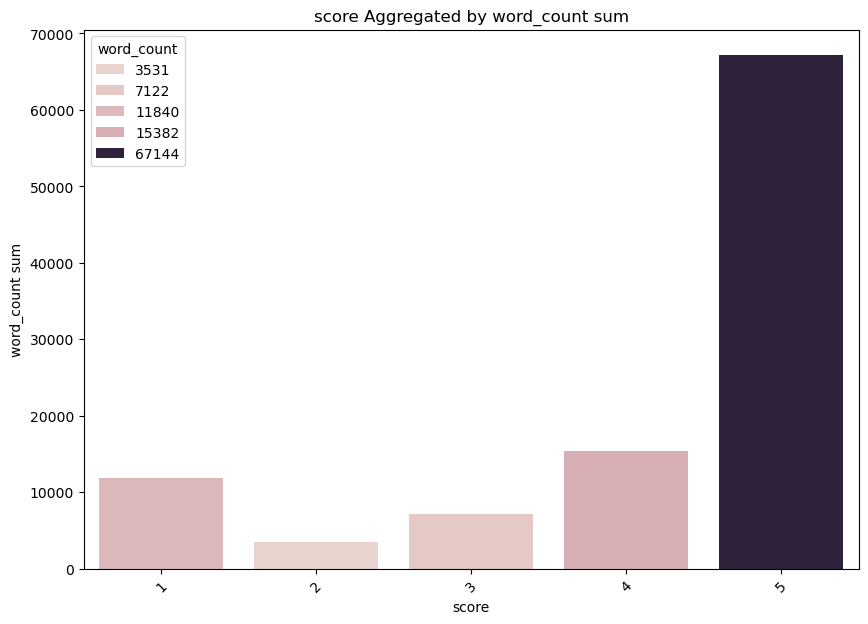

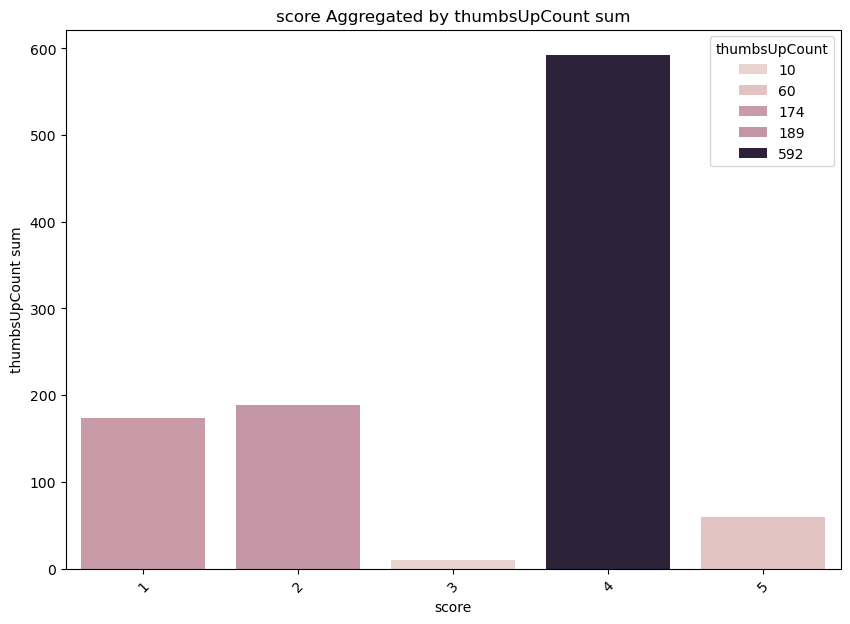

In [26]:
columns_to_test = ["review_length", "word_count", "thumbsUpCount"]

grouped_insights(df, columns_to_test, "score", "sum")


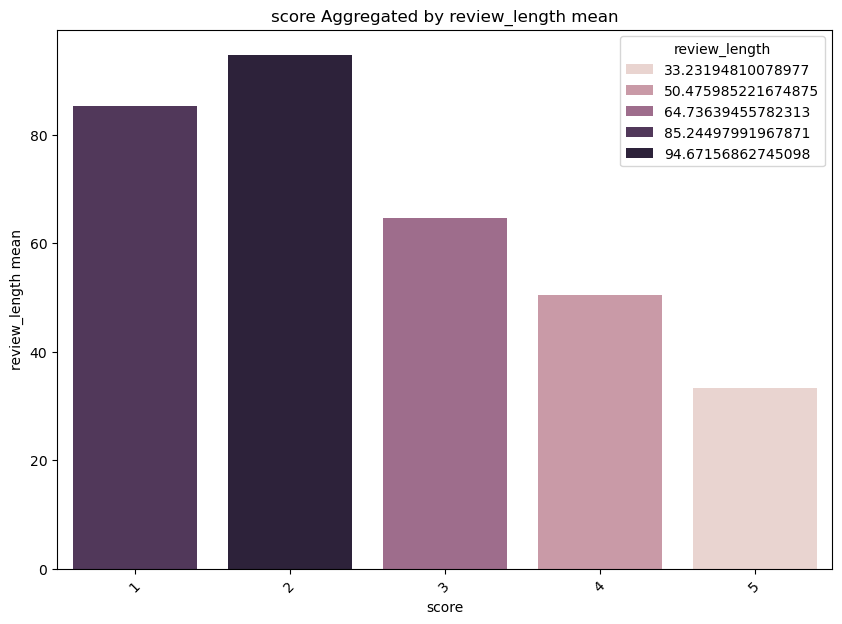

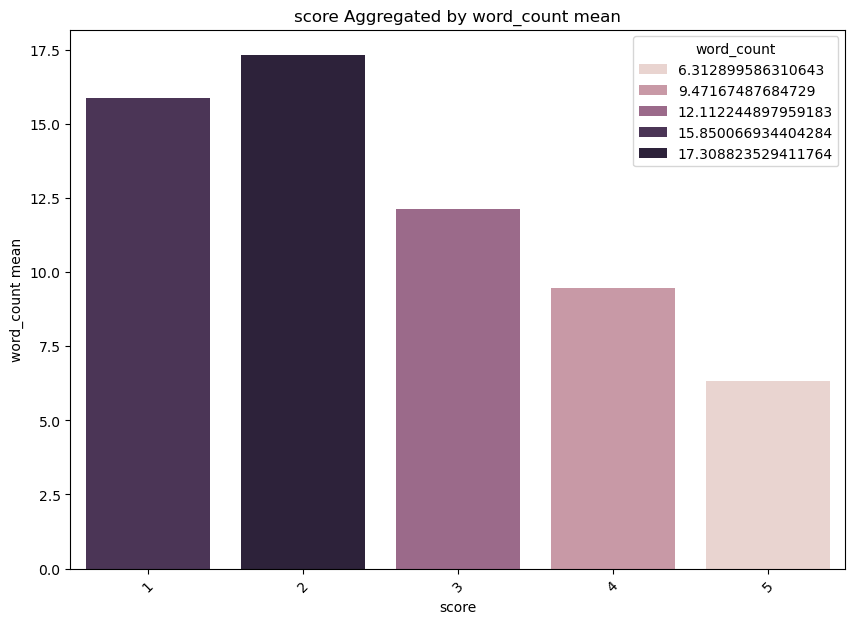

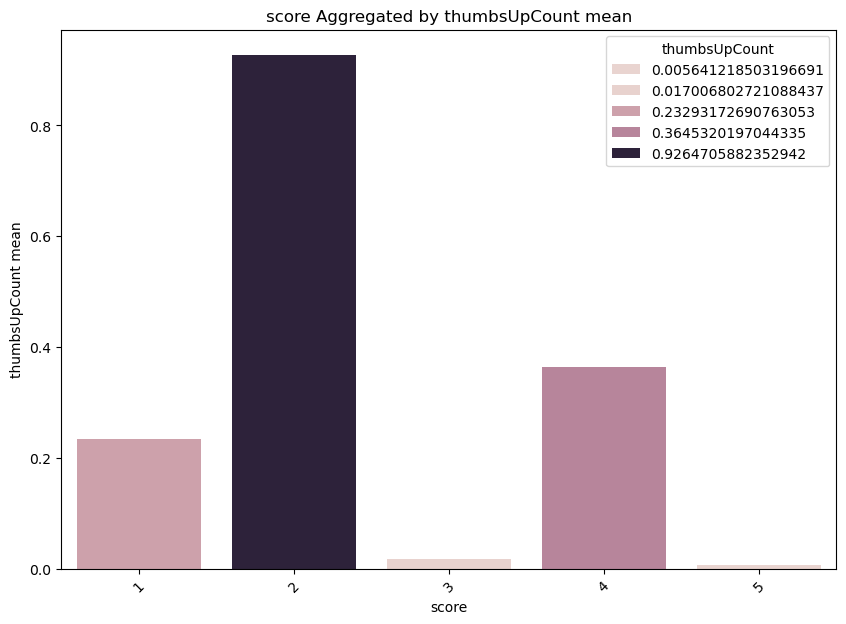

In [28]:
grouped_insights(df, columns_to_test, "score", "mean")

# Interesting insights here, the mean reveals that negative reviews generate a higher average of thumbs up counts, meaning that users might appreciate negative information over positive information.

In [29]:
df["at"] = pd.to_datetime(df["at"])
df["day"] = df["at"].dt.day
df["month"] = df["at"].dt.month
df["year"] = df["at"].dt.year

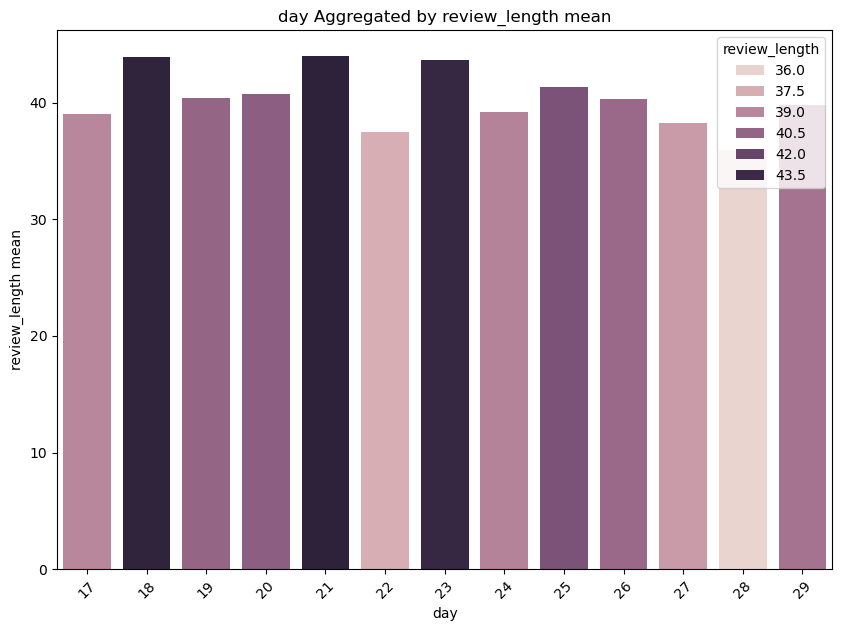

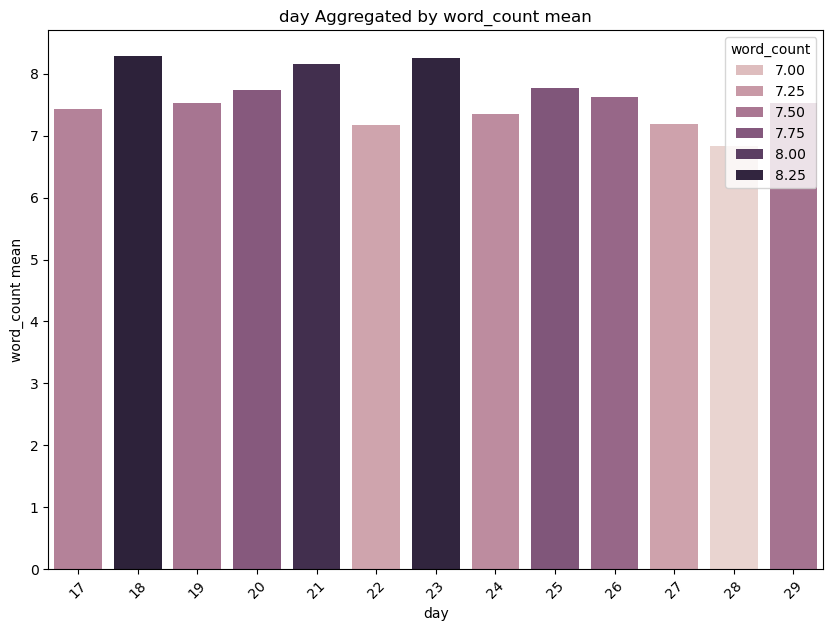

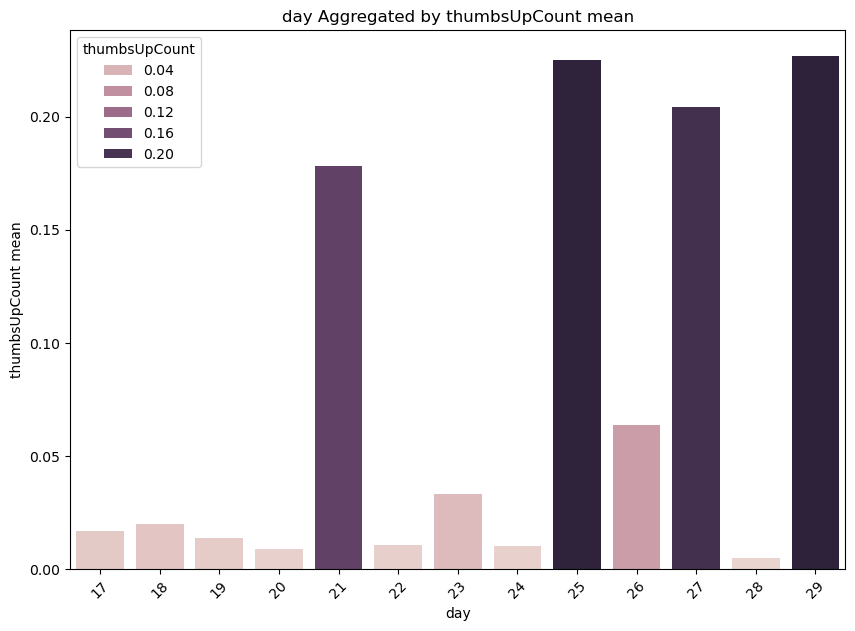

In [32]:
grouped_insights(df, columns_to_test, "day", "mean")

# Data Preprocessing

In [33]:
df["content"] = df["content"].apply(remove_stop_words)

# Reviews can be in other languages besides English, our function will reduce this review to an empty string, we need to address this issue. With text data, we could be imputing our own biases into the dataset if we decide to fill the values with most frequent words. It might be best to drop these values.

<AxesSubplot:xlabel='score', ylabel='Counts'>

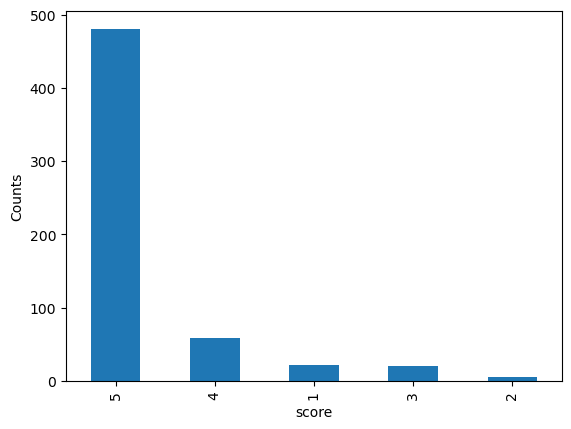

In [34]:
df[df["content"] ==""]["score"].value_counts().plot.bar(xlabel="score", ylabel="Counts")

In [35]:
df.shape

(13799, 9)

In [36]:
df = df[df["content"].str.strip() !=""]

In [37]:
df.shape

(13214, 9)

# Separate Feature Variables

In [38]:
X, y = df["content"], df["score"]

# Encode Y column

In [40]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

NUM_CLASSES = len(encoder.classes_)

one_hot_encoded_y = to_categorical(y_encoded, num_classes=NUM_CLASSES)

# Bert Model

In [41]:
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

In [42]:
seq = [sequence for sequence in X]
model_inputs = tokenizer(seq, padding=True, return_tensors="tf")

In [44]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"], one_hot_encoded_y))

In [45]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [46]:
len_dataset = len(dataset)

In [47]:
train = dataset.take(int(len_dataset *.7))
test = dataset.skip(int(len_dataset *.7)).take(int(len_dataset*.2))
val = test = dataset.skip(int(len_dataset *.9)).take(int(len_dataset*.1))

In [49]:
earl_stopping = EarlyStopping(
  monitor="val_loss",
  patience=10,
  min_delta=0.01,
  restore_best_weights=True,
  verbose=0,
  mode="min"
)